In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import os
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as immg
from sklearn.model_selection import StratifiedKFold,KFold
from PIL import Image
import skimage as sk

In [ ]:
def segment(indir, outdir, imgname, showimg = False, split = True, savefull = True, splitdir = None):
  imgpath = indir + "/" + imgname + ".png"
  col = np.array(Image.open(imgpath))
  col = col[:,:,:3]
  #Convolutional Filter
  lf = 10

  filter = (np.array([np.ones(lf), np.zeros(lf), -1*np.ones(lf)])).T
  #print(filter)

  col3 = np.copy(col)
  crshape = col3.shape + np.array([lf,filter.shape[0],0])
  #print(crshape)

  Col_rows3 = 255*np.ones(crshape)
  #print(Col_rows3.shape)

  Col_rows3[:col3.shape[0], :col3.shape[1]] = col3
  #print(Col_rows3.shape)

  Psums = np.sum(Col_rows3, axis=2)
  #print(Psums.shape)
  f_rows = np.zeros_like(Psums)

  # plt.imshow(Psums)
  # plt.show()
  #print(col.shape)

  for r in range(col.shape[0]):
    for c in range(col.shape[1]):
      f_rows[r][c] = np.sum(Psums[r][c:c+lf]) - np.sum(Psums[r+2][c:c+lf])
  fsum = np.sum(f_rows, axis=1)
  fsum = fsum[:-lf]
  assert len(fsum) == col.shape[0]
  #gap check filter

  thr = 200
  h = 5
  h2 = 10
  w = 5
  margin = 70

  #print(col.shape)

  gsum = np.copy(fsum)

  for r in range(max(h,h2),col.shape[0]):
    gap = False
    for c in range(margin, col.shape[1]-margin):
      window = np.min(col[r-h:r+h, c:c+w])
      window2 = np.min(col[r-h2:r+h2, c])
      if window > thr and window2 > thr:
        gap = True
    if gap:
      gsum[r] = 0
    # else:
    #   print(r)
  ## As Before:

  grank = np.argsort(gsum)
  #print(hrank)

  thr = 200000
  lineguesses = np.array([])

  for r in grank:
    if np.abs(gsum[r]) > thr:
      lineguesses = np.append(lineguesses, r)

  lineguesses = np.sort(lineguesses)

  Col_rows5 = np.copy(col)

  toplines = np.array([])
  botlines = np.array([])
  min_dist = 40

  for i in range(len(lineguesses)):
    line = lineguesses[i]
    if i == 0 or line - toplines[-1] > min_dist:
      toplines = np.append(toplines, line)

  rl = np.flip(lineguesses)
  #print(rl)

  for i in range(len(rl)):
    line = rl[i]
    if i == 0 or botlines[-1] - line > min_dist:
      botlines = np.append(botlines, line)
  botlines = np.flip(botlines)

  assert len(botlines) == len(toplines)

  midlines = np.round(np.add(toplines, botlines)/2)

  for r in toplines:
    row = int(r)
    Col_rows5[row][:] = [0,255,0]

  for r in botlines:
    row = int(r)
    Col_rows5[row][:] = [0,0,255]

  for r in midlines:
    row = int(r)
    Col_rows5[row][:] = [255,0,0]
    Col_rows5[row+1][:] = [255,0,0]
    

  #print(Col_rows5.shape)
  if showimg:
    plt.imshow(Col_rows5)
    plt.show()
    plt.show()
  
  if savefull:
    lineguess_4 = Image.fromarray(Col_rows5)
    lineguess_4.save(outdir + "/" + "fullseg_" + imgname + ".png")

  if split:
    sd = splitdir + imgname
    if not os.path.exists(sd):
        os.mkdir(sd)
    segcol = np.copy(col)
    for i in range(len(midlines)-1):
      r1 = int(midlines[i])
      r2 = int(midlines[i+1])
      seg = Image.fromarray(segcol[r1:r2])
      segname = sd + "/" + imgname + "_seg" + str(i) + ".png"
      #print(segname)
      seg.save(segname)
      
  

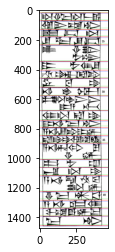

In [ ]:
segment("Inputs", "Outputs", "Col1.2", showimg = True, split = True, savefull = True, splitdir = "Outputs/")

In [ ]:
!cd /content/Outputs/
!zip -r Outputs/Col1.2.zip Outputs/Col1.2

	zip warning: name not matched: Outputs/Col1.2

zip error: Nothing to do! (try: zip -r Outputs/Col1.2.zip . -i Outputs/Col1.2)
